In [1]:
import pandas as pd
import numpy as np
import os

# Load the dataset we created in the previous notebook
data_path = '../../data/eth_usd_h4_features.csv'
df = pd.read_csv(data_path, index_col='timestamp', parse_dates=True)

print("Data loaded successfully.")
display(df.head())

Data loaded successfully.


,open,high,low,close,volume,ichimoku_senkou_span_a,ichimoku_senkou_span_b,ichimoku_tenkan_sen,ichimoku_kijun_sen,ichimoku_chikou_span,...,BBB_20_2.0,BBP_20_2.0,ATRr_14,ADX_14,DMP_14,DMN_14,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-02-03 04:00:00,851.99,923.00,846.01,915.01,40156.097304,1143.185,1064.5,878.190,948.715,820.00,...,39.385867,0.264228,73.748426,43.819631,4.644883,30.987304,-218.738333,0,1,0
2018-02-03 08:00:00,915.01,959.00,899.09,959.00,22656.381253,1135.885,1064.5,873.455,947.215,824.99,...,39.511518,0.387522,72.759967,44.785890,7.905826,29.164824,-194.621667,0,1,0
2018-02-03 12:00:00,959.00,998.00,948.79,958.50,44889.215737,1135.885,1064.5,862.215,947.215,750.04,...,39.130006,0.401247,71.077826,44.558193,11.434107,27.722540,-190.396667,0,1,0
2018-02-03 16:00:00,958.50,984.00,944.10,978.99,28552.169031,1135.320,1064.5,862.215,942.290,801.47,...,38.132068,0.468765,68.850838,44.400141,10.960806,27.061557,-158.961667,0,1,0
2018-02-03 20:00:00,978.99,989.25,953.96,969.40,20775.688846,1120.580,1064.5,862.215,934.715,829.95,...,37.198745,0.458460,66.453634,44.098913,11.109344,26.035060,-134.805000,0,1,0


In [2]:
def define_target(df, atr_multiplier_tp=3.0, atr_multiplier_sl=1.5, lookahead_candles=30):
    """
    Creates the target variable based on dynamic, volatility-based (ATR) targets.
    - 1: BUY (price went up by TP multiplier before going down by SL multiplier)
    - -1: SELL (price went down by TP multiplier before going up by SL multiplier)
    - 0: HOLD (neither happened within the lookahead window)
    
    This strategy enforces a Risk/Reward Ratio of approximately 2:1 (TP is 2x SL distance).
    """
    df['target'] = 0
    
    # Find the correct ATR column name automatically
    atr_column_name = next((col for col in df.columns if 'ATRr_' in col), None)
    if not atr_column_name:
        raise ValueError("ATR column not found in DataFrame. Please ensure it's calculated in Notebook 1.")
        
    for i in range(len(df) - lookahead_candles):
        entry_price = df['close'].iloc[i]
        atr_value = df[atr_column_name].iloc[i]
        
        # Define the price window to look into the future
        future_window_high = df['high'].iloc[i+1 : i+1+lookahead_candles]
        future_window_low = df['low'].iloc[i+1 : i+1+lookahead_candles]
        
        # --- Dynamic targets for a BUY signal ---
        take_profit_buy = entry_price + (atr_value * atr_multiplier_tp)
        stop_loss_buy = entry_price - (atr_value * atr_multiplier_sl)
        
        # --- Dynamic targets for a SELL signal ---
        take_profit_sell = entry_price - (atr_value * atr_multiplier_tp)
        stop_loss_sell = entry_price + (atr_value * atr_multiplier_sl)
        
        # --- Check for BUY signal outcome ---
        # Find the first time the high hits the TP and the low hits the SL
        buy_profit_hit_time = future_window_high[future_window_high >= take_profit_buy].first_valid_index()
        buy_loss_hit_time = future_window_low[future_window_low <= stop_loss_buy].first_valid_index()
        
        # If the TP was hit, and either the SL was never hit or the TP was hit first
        if buy_profit_hit_time is not None and (buy_loss_hit_time is None or buy_profit_hit_time < buy_loss_hit_time):
            # Use .loc for safe, explicit assignment to the DataFrame
            df.loc[df.index[i], 'target'] = 1
            continue

        # --- Check for SELL signal outcome ---
        # Find the first time the low hits the TP and the high hits the SL
        sell_profit_hit_time = future_window_low[future_window_low <= take_profit_sell].first_valid_index()
        sell_loss_hit_time = future_window_high[future_window_high >= stop_loss_sell].first_valid_index()
            
        # If the TP was hit, and either the SL was never hit or the TP was hit first
        if sell_profit_hit_time is not None and (sell_loss_hit_time is None or sell_profit_hit_time < sell_loss_hit_time):
            df.loc[df.index[i], 'target'] = -1
            continue
            
    return df

print("New dynamic define_target function created and ready.")

New dynamic define_target function created and ready.


Target labeling complete.

Target Distribution:
target
 0    7072
 1    4796
-1    4717
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of Target Labels (0=Hold, 1=Buy, -1=Sell)'}, xlabel='target'>

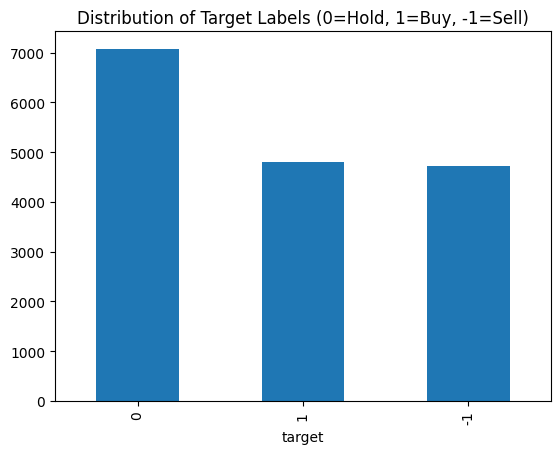

In [3]:
# Apply the function to our DataFrame
# This can take a minute or two to run as it's iterating through the data
labeled_df = define_target(df)

print("Target labeling complete.")

# Analyze the distribution of our targets
target_distribution = labeled_df['target'].value_counts()
print("\nTarget Distribution:")
print(target_distribution)

# Plot the distribution
target_distribution.plot(kind='bar', title='Distribution of Target Labels (0=Hold, 1=Buy, -1=Sell)')

In [4]:
# Save the final labeled DataFrame for the model training stage
output_path = '../../data/eth_usd_h4_labeled.csv'
labeled_df.to_csv(output_path)

print(f"Labeled data saved successfully to: {output_path}")

Labeled data saved successfully to: ../../data/eth_usd_h4_labeled.csv
